# **충남대학교 - 컴퓨터 그래픽스** 

학번 : 202004183

이름 : 박시준

## 과제 안내 사항 
딥러닝 과제는 따로 보고서를 받지 않을 예정입니다. 

대신 과제 구현 시 주석을 꼭 달아서 충분히 구현한 내용에 대한 설명을 해주시면 되겠습니다.

과제 제출 기한
11월 28일 월요일 23시 59분
제출 파일 : .ipynb 파일 


## kaggle API 연동


In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sijunpark","key":"171e9639a6f6e51562f030fe64781507"}'}

In [3]:
!ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         68           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         98           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        732           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge        147           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1206           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      14038           False  


In [5]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.89G/3.89G [02:59<00:00, 23.7MB/s]
100% 3.89G/3.89G [02:59<00:00, 23.2MB/s]


In [6]:
!unzip semantic-drone-dataset

Archive:  semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/016.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/018.png  
  inflating: RGB_color_im

## Import Libraries

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

     |████████████████████████████████| 102 kB 6.1 MB/s 
     |████████████████████████████████| 376 kB 44.7 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
cuda


## Preprocessing


In [8]:
IMAGE_PATH = 'dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'dataset/semantic_drone_dataset/label_images_semantic/'

In [9]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [10]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)


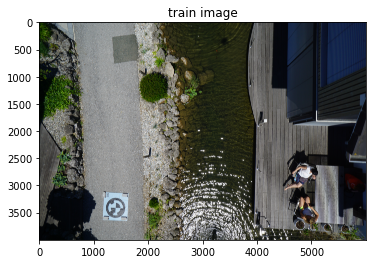

In [11]:
# 데이터 확인 
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
print('Image Size', np.asarray(img).shape)


plt.imshow(img)
plt.title('train image')
plt.show()

Mask Size (4000, 6000)


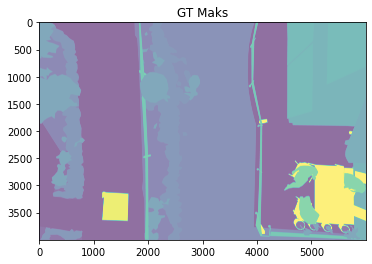

In [12]:
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Mask Size', np.asarray(mask).shape)
plt.imshow(mask, alpha=0.6)
plt.title('GT Maks')
plt.show()

## Custom DataSet Loader


In [13]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
  
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [14]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# image 크기를 450, 600으로 resize 
t_train = A.Compose([A.Resize(450, 600, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])
t_val = A.Compose([A.Resize(450, 600, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
# batch size 3 
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

Feature batch shape: torch.Size([3, 3, 450, 600])
Labels batch shape: torch.Size([3, 450, 600])


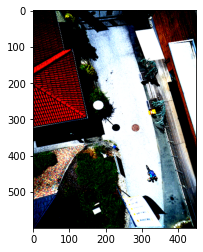

Label: tensor([[ 0,  9,  9,  ...,  9,  9,  9],
        [ 0,  9,  9,  ...,  9,  9,  9],
        [ 0,  9,  9,  ...,  9,  9,  9],
        ...,
        [ 0,  9,  9,  ..., 13, 13, 13],
        [ 0,  9,  9,  ..., 13, 13, 13],
        [ 0,  0,  0,  ..., 13, 13, 13]])


In [15]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
import matplotlib.pyplot as plt
plt.imshow(img.permute(2,1,0))
plt.show()
print(f"Label: {label}")

## Declare Eval Metric

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

## UNet Architecture

In [18]:
import torch.nn as nn
from torch.nn import functional as F


class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blocks(x)


class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.encoder = Block(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decoder = Block(in_channels, out_channels)

    def forward(self, x, encoder_features):
        x = self.up(x)
        diffY = encoder_features.size()[2] - x.size()[2]
        diffX = encoder_features.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([encoder_features, x], dim=1)
        x = self.decoder(x)
        return x


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = Block(3, 64)
        self.encoder1 = Encoder(64, 128)
        self.encoder2 = Encoder(128, 256)
        self.encoder3 = Encoder(256, 512)
        self.encoder4 = Encoder(512, 1024)

        self.decoder1 = Decoder(1024, 512)
        self.decoder2 = Decoder(512, 256)
        self.decoder3 = Decoder(256, 128)
        self.decoder4 = Decoder(128, 64)
        self.output = nn.Conv2d(64, 23, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4)
        x = self.decoder2(x, x3)
        x = self.decoder3(x, x2)
        x = self.decoder4(x, x1)
        x = self.output(x)
        x = self.softmax(x)
        return x

## Unet Training (Skip Connection O)

In [19]:
model = UNet()

In [20]:
model

UNet(
  (input): Block(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (encoder1): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder): Block(
      (blocks): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [21]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_Skip_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [22]:
max_lr = 5e-4
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss() # pixel-wise cross entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.068 
Epoch:1/5.. Train Loss: 3.019.. Val Loss: 3.068.. Train mIoU:0.069.. Val mIoU: 0.092.. Train Acc:0.355.. Val Acc:0.437.. Time: 4.88m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 3.068 >> 2.637 
Epoch:2/5.. Train Loss: 2.781.. Val Loss: 2.637.. Train mIoU:0.088.. Val mIoU: 0.094.. Train Acc:0.513.. Val Acc:0.618.. Time: 4.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.637 >> 2.623 
Epoch:3/5.. Train Loss: 2.680.. Val Loss: 2.623.. Train mIoU:0.097.. Val mIoU: 0.111.. Train Acc:0.559.. Val Acc:0.621.. Time: 4.54m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.623 >> 2.586 
saving model...
Epoch:4/5.. Train Loss: 2.634.. Val Loss: 2.586.. Train mIoU:0.110.. Val mIoU: 0.120.. Train Acc:0.596.. Val Acc:0.642.. Time: 4.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.586 >> 2.563 
Epoch:5/5.. Train Loss: 2.626.. Val Loss: 2.563.. Train mIoU:0.114.. Val mIoU: 0.120.. Train Acc:0.603.. Val Acc:0.662.. Time: 4.55m
Total time: 23.13 m


In [23]:
torch.save(model, 'Unet-Skip-True.pt')

In [24]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

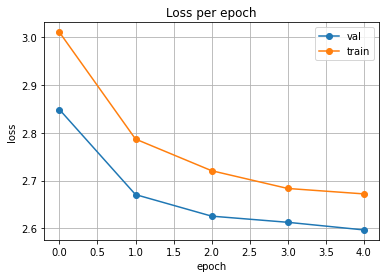

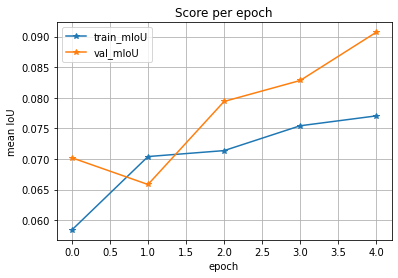

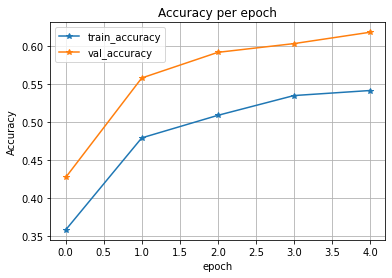

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [25]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

# Test data 
t_test = A.Resize(450, 600, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [26]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

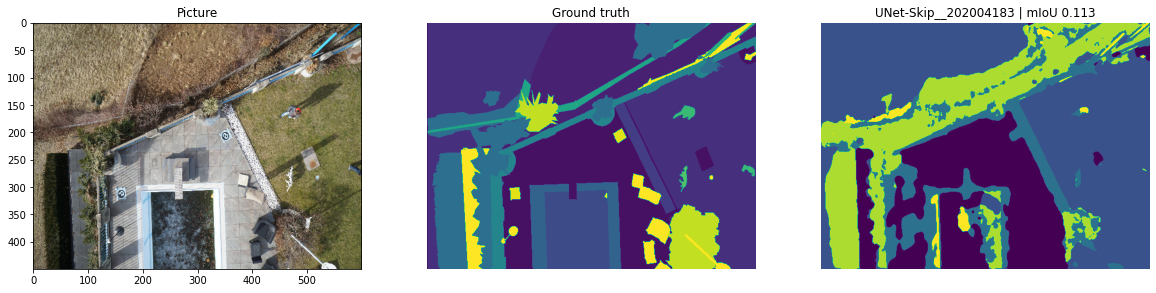

In [27]:
image, mask = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-Skip__202004183 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

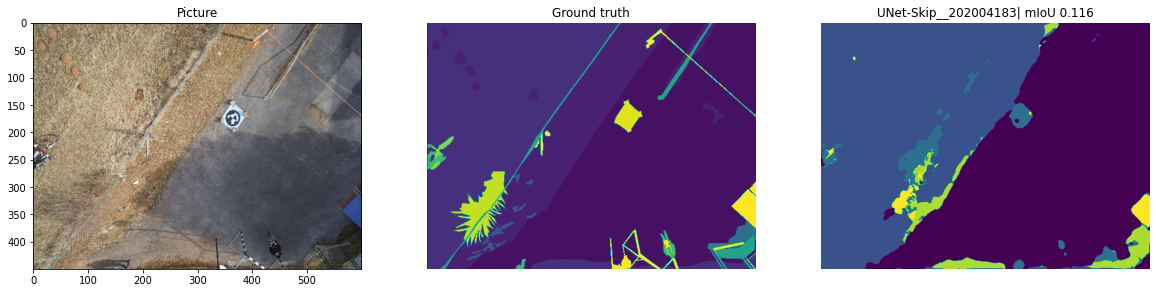

In [28]:
image, mask = test_set[1]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-Skip__202004183| mIoU {:.3f}'.format(score))
ax3.set_axis_off()

## Unet Architecture Not Skip Connection


In [29]:
import torch.nn as nn
from torch.nn import functional as F


class Block2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blocks(x)


class Encoder2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = Block2(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(x)
        x = self.encoder(x)
        return x


class Decoder2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.decoder = Block2(in_channels, out_channels)

    def forward(self, x, encoder_size):
        x = self.up(x)
        diffY = encoder_size[2] - x.size()[2]
        diffX = encoder_size[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = self.decoder(x)
        return x


class UNetNoSkip(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = Block2(3, 64)
        self.encoder1 = Encoder2(64, 128)
        self.encoder2 = Encoder2(128, 256)
        self.encoder3 = Encoder2(256, 512)
        self.encoder4 = Encoder2(512, 1024)

        self.decoder1 = Decoder2(1024, 512)
        self.decoder2 = Decoder2(512, 256)
        self.decoder3 = Decoder2(256, 128)
        self.decoder4 = Decoder2(128, 64)
        self.output = nn.Conv2d(64, 23, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.input(x)
        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x4 = self.encoder3(x3)
        x5 = self.encoder4(x4)

        x = self.decoder1(x5, x4.size())
        x = self.decoder2(x, x3.size())
        x = self.decoder3(x, x2.size())
        x = self.decoder4(x, x1.size())
        x = self.output(x)
        x = self.softmax(x)

        return x

## Unet Training (Skip Connection X)

In [30]:
model = UNetNoSkip()

In [31]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image);
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-No_skip_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [32]:
max_lr = 5e-4
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.917 
Epoch:1/5.. Train Loss: 3.025.. Val Loss: 2.917.. Train mIoU:0.047.. Val mIoU: 0.053.. Train Acc:0.289.. Val Acc:0.334.. Time: 4.61m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.917 >> 2.719 
Epoch:2/5.. Train Loss: 2.835.. Val Loss: 2.719.. Train mIoU:0.064.. Val mIoU: 0.075.. Train Acc:0.420.. Val Acc:0.514.. Time: 4.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.719 >> 2.690 
Epoch:3/5.. Train Loss: 2.774.. Val Loss: 2.690.. Train mIoU:0.068.. Val mIoU: 0.076.. Train Acc:0.486.. Val Acc:0.601.. Time: 4.56m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.690 >> 2.650 
saving model...
Epoch:4/5.. Train Loss: 2.736.. Val Loss: 2.650.. Train mIoU:0.074.. Val mIoU: 0.086.. Train Acc:0.526.. Val Acc:0.628.. Time: 4.55m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/5.. Train Loss: 2.712.. Val Loss: 2.656.. Train mIoU:0.079.. Val mIoU: 0.086.. Train Acc:0.561.. Val Acc:0.619.. Time: 4.53m
Total time: 22.84 m


In [33]:
torch.save(model, 'Unet-NoSkip-True.pt')

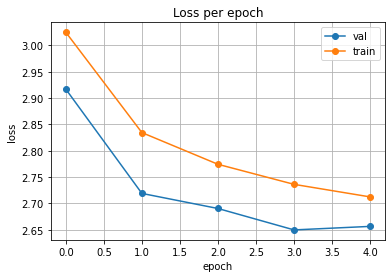

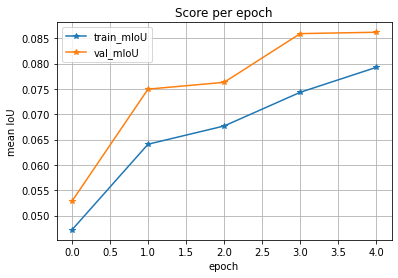

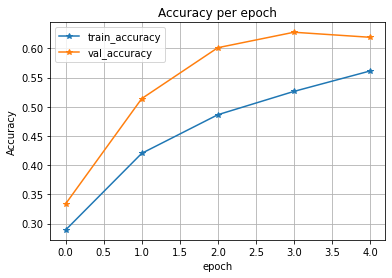

In [34]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [35]:
t_test = A.Resize(450, 600, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

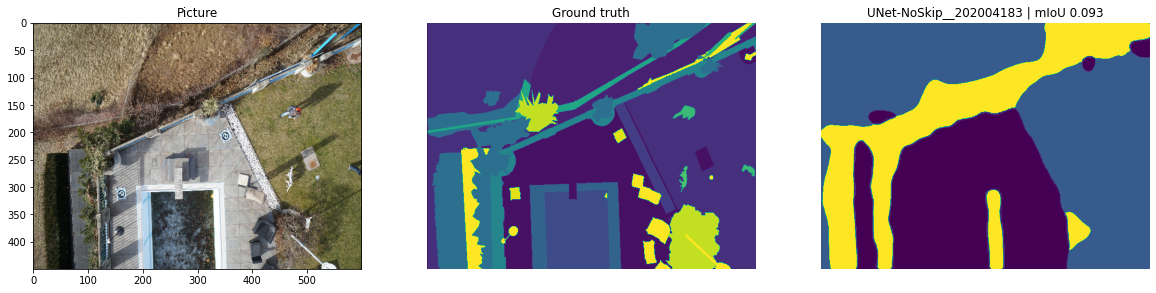

In [36]:
image, mask = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-NoSkip__202004183 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

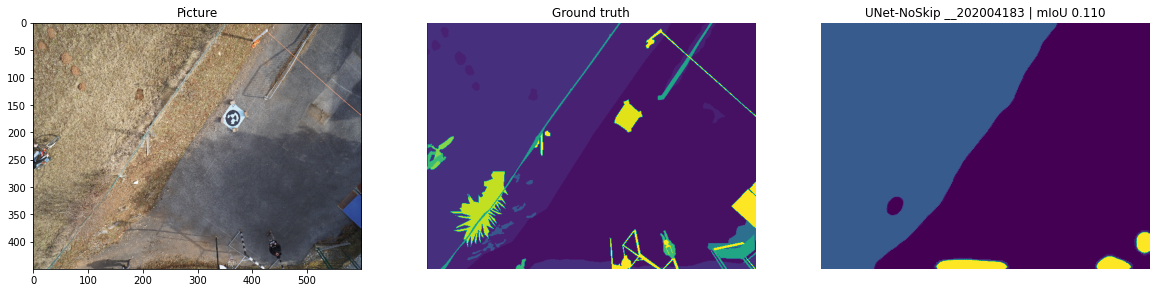

In [37]:
image, mask = test_set[1]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-NoSkip __202004183 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()



## **과제 수행 부분** 
## FCN 16 구현


In [38]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# image size를 384 x 576으로 Resize 
t_train = A.Compose([A.Resize(384, 576, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])
t_val = A.Compose([A.Resize(384, 576, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip()])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

In [39]:
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models
from torchvision.models.vgg import VGG

# 기학습된 모델 사용 건드리지 말 것.

ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

In [40]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        # 사전 VGG 모델 호출하는 코드
        self.pretrained_net = pretrained_net
        
        #--------------------

        self.relu    = nn.ReLU()
        # 2배 upsampling 
        # 512 h/32 w/32를 2x upsamping을 해주기 위해 입력 512, 출력 512로하고 2배 업샘플링을 해줍니다. 이떄 아웃패딩은 1로 줍니다.
        self.deconv1 = nn.ConvTranspose2d(512,512, kernel_size = 3, stride = 2,padding = 1, output_padding = 1, bias =False)

        #512 h/16 w/16을 1x1 convolution을 해줍니다.
        self.conv1 = nn.Conv2d(512,512,1)

        #이제 위에서 나온 두 결과를 Relu를 한 후 합쳐준뒤 Batch Norm을 통과를 시켜 줍니다.
        self.bn1 = nn.BatchNorm2d(512)
        # 16배 upsampling 
        #나온 결과는 이제 512 h/16 w/16 이 나옵니다 여기서16배 샘플링을 해주기 위해, shape를 일치 시키기 위해 아웃패딩은 2 커널은 16 스트라이드는 16을 하고 들어오는건 512, 나가는건 32로 줄여줍니다.
        self.deconv2 = nn.ConvTranspose2d(512,32, kernel_size = 16, stride = 16,padding = 1, output_padding = 2, bias =False)
        #32로 줄어든 것을 batchnorm을 통과 시켜 줍니다
        self.bn2     = nn.BatchNorm2d(32)
        # 픽셀 별로 클래스 출력하기 위한 계층
        self.classifier = nn.Conv2d(32,n_class,1)

        #----------------
    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               
        score = self.bn1(score + self.conv1(x4))       
        score = self.bn2(self.relu(self.deconv2(score)))  
        score = self.classifier(score)                    

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [41]:
vgg_model = VGGNet(requires_grad=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [42]:
model = FCN16s(pretrained_net=vgg_model, n_class=23)

In [43]:
# 모델 출력 결과 확인 
model

FCN16s(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [44]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'FCN16S_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [45]:
max_lr = 5e-4
epoch = 5
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.347 
Epoch:1/5.. Train Loss: 2.364.. Val Loss: 1.347.. Train mIoU:0.106.. Val mIoU: 0.157.. Train Acc:0.448.. Val Acc:0.712.. Time: 3.60m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:2/5.. Train Loss: 1.627.. Val Loss: 1.703.. Train mIoU:0.163.. Val mIoU: 0.133.. Train Acc:0.660.. Val Acc:0.586.. Time: 3.59m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.703 >> 0.979 
Epoch:3/5.. Train Loss: 1.380.. Val Loss: 0.979.. Train mIoU:0.172.. Val mIoU: 0.200.. Train Acc:0.675.. Val Acc:0.757.. Time: 3.58m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.979 >> 0.841 
Epoch:4/5.. Train Loss: 1.056.. Val Loss: 0.841.. Train mIoU:0.227.. Val mIoU: 0.236.. Train Acc:0.748.. Val Acc:0.788.. Time: 3.57m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.841 >> 0.804 
saving model...
Epoch:5/5.. Train Loss: 0.939.. Val Loss: 0.804.. Train mIoU:0.257.. Val mIoU: 0.254.. Train Acc:0.779.. Val Acc:0.796.. Time: 3.58m
Total time: 17.92 m


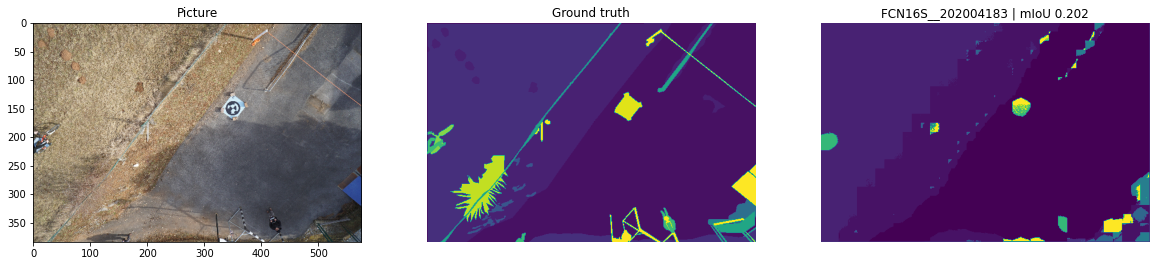

In [46]:
t_test = A.Resize(384, 576, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

image, mask = test_set[1]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('FCN16S__202004183 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

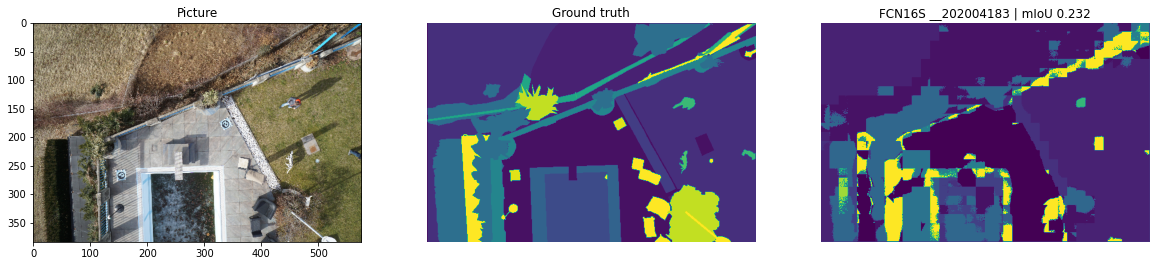

In [47]:
image, mask = test_set[4]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('FCN16S __202004183 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()